데이터 시각화 양식

양식의 순서는 지키되 참고만 하고 자유롭게 더하거나 빼서 분석하세요.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import json
import urllib
import requests
from bs4 import BeautifulSoup
import random
import time
import warnings
warnings.filterwarnings(action='ignore')

In [16]:
!pip install matplotlib
%matplotlib inline 
# %matplotlib notebook 

from numpy import sin, cos

from cycler import cycler
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
import platform

import matplotlib.font_manager as fm
fm.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rc('font', family='NanumBarunGothic')

from glob import glob

import scipy.integrate as integrate
import matplotlib.animation as animation
from collections import deque

# # seaborn 예제 파일 불러오기
# penguins = sns.load_dataset('penguins')

In [ ]:
# del df

# df.completed_at = pd.to_datetime(df.completed_at, )
# df.marketing_start_at = pd.to_datetime(df.marketing_start_at, )



In [83]:
sns.set_theme(style='whitegrid') 
df = pd.read_csv('./data/facam_vi.csv')
df.head()

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,pg,method,subcategory_title,marketing_start_at
0,970634,504760,201435,ORDER,CANCELLED,올인원 패키지 : 알고리즘 기술면접 완전 정복,프로그래밍,올인원,2021-03-28 15:00:11,90500,미적용,0,110500,COMM,VBANK,개발자 커리어,2018-11-11 00:00:00
1,970650,432862,203178,ORDER,CANCELLED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:16:53,96000,미적용,0,116000,COMM,CARD,영상 편집,2020-12-02 00:00:00
2,970657,72297,204246,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,[10% 할인] 시크릿코드 실무 완성편,19090,190900,COMM,CARD,프로그래밍,2021-03-04 00:00:00
3,970656,72297,204246,ORDER,CANCELLED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,미적용,0,190900,COMM,CARD,프로그래밍,2021-03-04 00:00:00
4,970658,478028,201797,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000,117500,COMM,CARD,PPT/보고서,2019-11-14 00:00:00


In [84]:
df.completed_at = pd.to_datetime(df.completed_at, )
df.marketing_start_at = pd.to_datetime(df.marketing_start_at, )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101102 entries, 0 to 101101
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      101102 non-null  int64         
 1   customer_id             101102 non-null  int64         
 2   course_id               101102 non-null  int64         
 3   type                    101102 non-null  object        
 4   state                   101102 non-null  object        
 5   course_title            101102 non-null  object        
 6   category_title          101102 non-null  object        
 7   format                  101102 non-null  object        
 8   completed_at            101102 non-null  datetime64[ns]
 9   transaction_amount      101102 non-null  int64         
 10  coupon_title            101102 non-null  object        
 11  coupon_discount_amount  101102 non-null  int64         
 12  sale_price              101102

> 17 columns, 101102 index, 1718734 rows, notnull data

In [85]:
df.describe()

,id,customer_id,course_id,transaction_amount,coupon_discount_amount,sale_price
count,1.011020e+05,101102.000000,101102.000000,1.011020e+05,101102.000000,1.011020e+05
mean,1.145511e+06,415909.561997,208729.604815,1.286851e+05,14423.185199,1.592345e+05
std,1.125048e+05,206627.373238,21281.637839,1.299967e+05,35684.365000,1.147219e+05
min,5.679930e+05,16.000000,2516.000000,-1.800000e+06,0.000000,0.000000e+00
25%,1.047142e+06,228975.000000,203146.000000,8.900000e+04,0.000000,1.100000e+05
50%,1.133842e+06,500265.500000,203787.000000,1.190000e+05,0.000000,1.340000e+05
75%,1.238848e+06,565941.000000,204870.000000,1.584000e+05,10000.000000,1.710000e+05
max,1.381657e+06,670896.000000,300000.000000,1.800000e+06,674000.000000,1.800000e+06


# 매출 분석

## preprocessing refer
> 'type' column 의 'PAYMENT'(결제완료) 와 'REFUND'(환불)이 'state' column 에서 'COMPLETED' 인 값들의 합   

> 'completed_at' clone column 'completed_c' 을 추가. 'completed_c' dtype 으로 변경 후 연/월/일/시간으로 나눔

> df 에서 결제 승인이 처음 시작된 일시와 종료 일시 확인(마케팅시간도참고)

## df의 총 매출

In [86]:
# 'type'(구매상태), 'state'(진행상황), 'transaction_amount' column 추출
s = df.loc[:, ['type', 'state', 'transaction_amount']]
s.head()

,type,state,transaction_amount
0,ORDER,CANCELLED,90500
1,ORDER,CANCELLED,96000
2,PAYMENT,COMPLETED,171810
3,ORDER,CANCELLED,171810
4,PAYMENT,COMPLETED,97500


In [87]:
# 'type' column 의 'PAYMENT', 'REFUND' 와 'state' column 의 'COMPLEATED' 추출 
sales = s[(s['type'] == 'PAYMENT') + (s['type'] == 'REFUND') & (s['state'] == 'COMPLETED')]
sales.index = range(len(sales))
sales

,type,state,transaction_amount
0,PAYMENT,COMPLETED,171810
1,PAYMENT,COMPLETED,97500
2,PAYMENT,COMPLETED,96000
3,PAYMENT,COMPLETED,263000
4,PAYMENT,COMPLETED,91000
...,...,...,...
53035,PAYMENT,COMPLETED,212000
53036,PAYMENT,COMPLETED,149000
53037,PAYMENT,COMPLETED,159000
53038,PAYMENT,COMPLETED,96000


In [88]:
# 'transaction_amount' column 총합으로 총 매출 및 (추가할것)취소율 확인 'type' column 'REFUND' / 'PAYMENT' * 100
# len(s['type'] == 'REFUND') / len(s['type'] == 'PAYMENT') *100
sale = sales['transaction_amount'].sum() 
pay = len(sales[sales['type'] == 'PAYMENT']) 
re = len(sales[sales['type'] == 'REFUND'])
print(f'결제완료 {pay} 건 중 환불 {re} 건,\n총 매출액 : {sale} 원') 
# print("환불율' : %.3f%%" % (len(sales[sales['type'] == 'PAYMENT'])  / len(sales[sales['type'] == 'REFUND']) * 100))

결제완료 49415 건 중 환불 3625 건,
총 매출액 : 5972719534 원


In [105]:
# # 빼기할 수 있는 방법
# df.iloc[-1]['completed_at']
# df.iloc[0]['completed_at']
# s_period = df.iloc[-1]['completed_at'] - df.iloc[0]['completed_at']
# print(s_period)

180 days 23:25:36


취소 환불이 +, - 로 잘 되어있다는 가정하에
> 총 매출 약 60억원

## 시간대, 요일, 일, 주, 월, 분기, 총 매출(반기), 6개월간 추이

In [89]:
# 'completed_at' column, 연, 월, 일 나누기
df['Year'] = df['completed_at'].dt.year
df['Month'] = df['completed_at'].dt.month
df['Day'] = df['completed_at'].dt.day
df['Hour'] = df['completed_at'].dt.hour
df['Day of week'] = df['completed_at'].dt.day_name()
df['Week'] = df['completed_at'].dt.week
df[df.columns[-6:]]

,Year,Month,Day,Hour,Day of week,Week
0,2021,3,28,15,Sunday,12
1,2021,3,28,15,Sunday,12
2,2021,3,28,15,Sunday,12
3,2021,3,28,15,Sunday,12
4,2021,3,28,15,Sunday,12
...,...,...,...,...,...,...
101097,2021,9,25,14,Saturday,38
101098,2021,9,25,14,Saturday,38
101099,2021,9,25,14,Saturday,38
101100,2021,9,25,14,Saturday,38


In [77]:
# 결제 및 환불로 기준점
type_a = df['type'][df['type'] != 'ORDER']

### 시간대별 매출 그래프

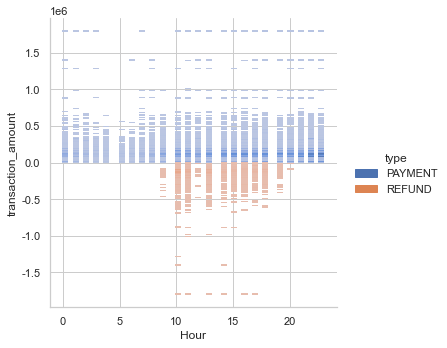

In [78]:
sns.displot(data = df, x = 'Hour', y = 'transaction_amount', hue = type_a)

### 요일별 매출 그래프

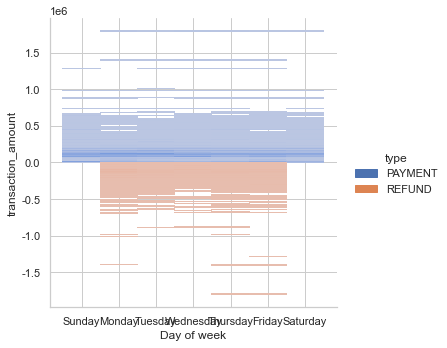

In [115]:
sns.displot(data = df, x = 'Day of week', y = 'transaction_amount', hue = type_a)

### 일별 매출 그래프

<AxesSubplot:xlabel='Day', ylabel='transaction_amount'>

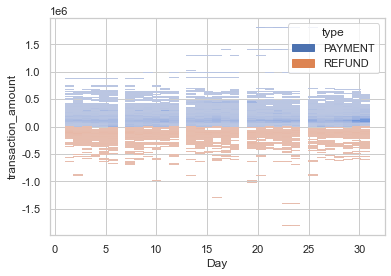

In [80]:
sns.histplot(data = df, x = 'Day', y = 'transaction_amount', hue = type_a)

### 주별 매출 그래프 , 수정필요(코드도)

<AxesSubplot:xlabel='Week', ylabel='transaction_amount'>

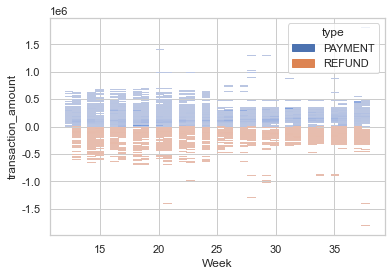

In [81]:
sns.histplot(data = df, x = 'Week', y = 'transaction_amount', hue = type_a)

### 월별 매출 그래프

<AxesSubplot:xlabel='Month', ylabel='transaction_amount'>

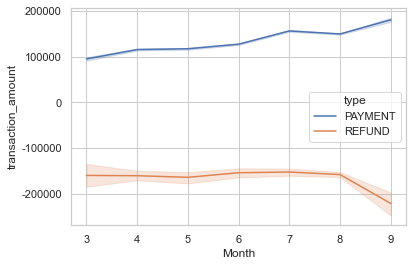

In [112]:
sns.lineplot(data = df, x = 'Month', y = 'transaction_amount', hue = type_a)

### 6개월(반기) 총매출 그래프

<AxesSubplot:ylabel='transaction_amount'>

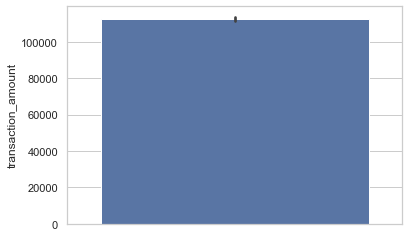

In [121]:
sns.barplot(data = sales, y = 'transaction_amount', hue = type_a)

# 강의 분석

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101102 entries, 0 to 101101
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      101102 non-null  int64         
 1   customer_id             101102 non-null  int64         
 2   course_id               101102 non-null  int64         
 3   type                    101102 non-null  object        
 4   state                   101102 non-null  object        
 5   course_title            101102 non-null  object        
 6   category_title          101102 non-null  object        
 7   format                  101102 non-null  object        
 8   completed_at            101102 non-null  datetime64[ns]
 9   transaction_amount      101102 non-null  int64         
 10  coupon_title            101102 non-null  object        
 11  coupon_discount_amount  101102 non-null  int64         
 12  sale_price              101102

## 전체 강의 수

In [134]:
# 판매된 강의 종 수 
len(df.course_title.unique())

610

## 전체 카테고리 수

In [135]:
# 판매된 강의 종 수 
len(df.category_title.unique())

14

## 가장많은(적은) 매출을 올린 강의 및 탑 10강의 매출추이

course_title 별 transaction_amount 구해야 하는데, 
transaction_amount 는 state의 'PAYMENT' 와 'REFUND' 중 type 이 'COMPLETE' 인 합 => sales

In [138]:
# sales 에 'course_title' column 추가
saless = sales['course_title'] = df['course_title'].dt.object



AttributeError: Can only use .dt accessor with datetimelike values

### 매출 상위 1~10위 까지의  강의  목록 

### 매출 상위 1~10위 강의 매출 추이 그래프(6개월간)

### 매출 하위 1~10위 강의목록

### 매출 하위 1~10위 강의 매출 추이 그래프(6개월간)

## 가장많은(적은) 매출을 올린 카테고리 탑 10카테고리 매출추이

### 매출 상위 1~10위 까지의  카테고리  목록

### 매출 상위 1~10위 카테고리 매출 추이 그래프(6개월간)

### 매출 하위 1~10위 카테고리목록

### 매출 하위 1~10위 카테고리 매출 추이 그래프(6개월간)

# 수강 신청 행동 패턴 분석

## cancelled 가장 많은 강좌(구매가 많은게 환불이 많은가? 주의)

### 취소가 많은  1~20위 까지의  강의  목록(cancelled)

### 취소가 가장 적은 1~20위 강의 목록

### 환불이 많은  1~20위 까지의  강의  목록(refund)

### 환불률이 가장 적은 1~20위 강의 목록

### 구매률과 환불률의 상관관계

# PG사 목록

## 기존 PG사 vs 신규 pg사 점유율 현황

### 기존 PG사 vs 신규 pg사 기간별 점유율 변동 변화추이

# VIP그룹 분석

## VIP 그룹 정의

## 일반 고객 평균 결제 횟수 vs VIP 고객 평균 결제 횟수

## VIP 그룹 특징

# 쿠폰 사용 분석

## 전체구매건 중 쿠폰사용한 구매비율

## 매출에 대한 쿠폰의 중요도 분석

# 패키지 강의 vs 단품 강의

# 레드는 과연 성공했는가?